# The transient Universe - Part 2

In [1]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 12

In [2]:
data =  np.load('../solutions/transient.npy')
time = data[:,0]
flux = data[:,1]
uncertainties = data[:,2]

Text(0, 0.5, 'flux')

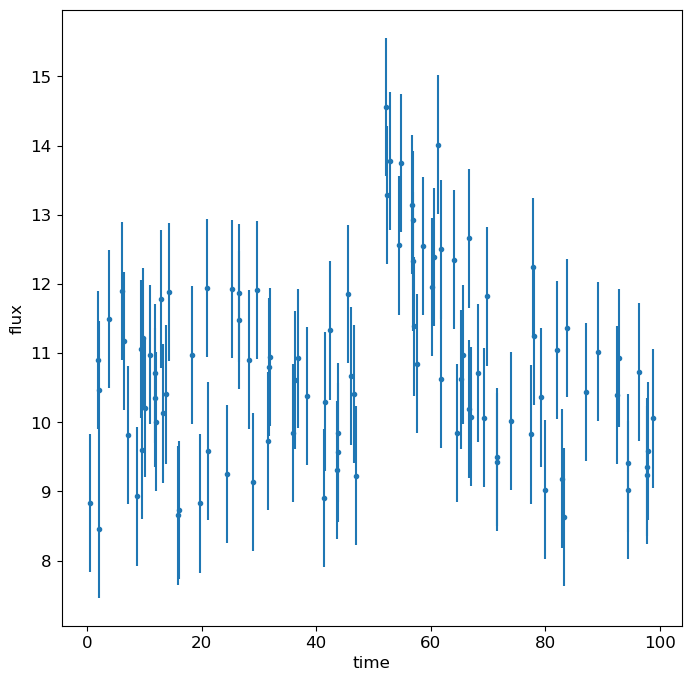

In [3]:
plt.errorbar(time, flux, yerr=uncertainties, fmt=".")
plt.xlabel("time")
plt.ylabel("flux")

### 7) 
Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

### 8) 
Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)


In [4]:
def burst_model(theta,t):
    A,b,t_0,alpha = theta
    return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))

def gaussian_model(theta, t):
    A,b,t_0,sigma =theta
    return b + A*np.exp(-((t-t_0)**2)/(2*sigma**2))

In [5]:
#Initial parameters
A_in = 5
b_in = 10
t0_in =50
alpha_in = 0.1
sigma_in = 2

tgrid = np.linspace(0,100,100)

theta_b_in = np.array([A_in,b_in,t0_in,alpha_in])
theta_g_in = np.array([A_in,b_in,t0_in,sigma_in])

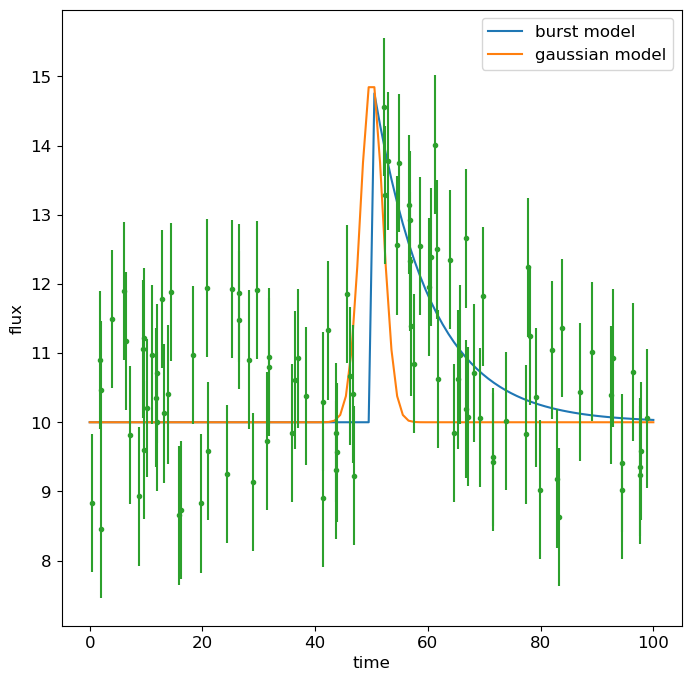

In [6]:
plt.plot(tgrid,burst_model(theta_b_in,tgrid), label="burst model")
plt.plot(tgrid,gaussian_model(theta_g_in,tgrid),label="gaussian model")
plt.errorbar(time, flux, yerr=uncertainties, fmt=".")
plt.xlabel("time")
plt.ylabel("flux")

plt.legend()
plt.show()

**dynesty**

In [7]:
import dynesty
import scipy.stats

ndim = 4

In [8]:
A_min,A_max, = 0,50
b_min, b_max = 0,50
t0_min, t0_max = 0,100
alpha_min , alpha_max = np.exp(-5),np.exp(5)
sigmaW_min,sigmaW_max =np.exp(-2),np.exp(2)

In [9]:
'''
def loglikelihood(theta, data , model = burst_model):
    x,y,sigma_y= data.T
    
    y_model = model(theta_b_in,x)
    return -0.5* np.sum((y-y_model)**2 / (sigma_y**2))
'''

def loglike(theta, data, model):
    x, y, sigma_y = data.T
    if model =='burst_model':
        y_fit = burst_model(theta, x)
    elif model == 'gaussian_model':
        y_fit = gaussian_model(theta, x)

    # Note I'm not tracking the normalization here! 
    # Ok because here I only care about the ratio between two evidences, not the evidence itself
    return -0.5 * np.sum((y-y_fit)**2 / sigma_y**2 ) 
def ptform(u,model):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=A_min,scale=A_max-A_min).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=b_min,scale=b_max-b_min).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0_min,scale=t0_max-t0_min).ppf(u[2])
   
    if model =='burst_model':
        x[3] = scipy.stats.loguniform.ppf(u[3],alpha_min,alpha_max)
    elif model =='gaussian_model':
        x[3] = scipy.stats.loguniform.ppf(u[3],sigmaW_min,sigmaW_max)
        #x[3] = scipy.stats.uniform(loc=sigmaWmin,scale=sigmaWmax-sigmaWmin).ppf(u[3])

    return x


'''
def ptform(u, model = burst_model):
    x = np.array(u)  # copy u

    x[0] = scipy.stats.uniform(loc=A_min,scale=A_max-A_min).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=b_min,scale=b_max-b_min).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0_min,scale=t0_max-t0_min).ppf(u[2])
   
    x[3] = scipy.stats.loguniform.ppf(u[3],alpha_min,alpha_max)

    return x
'''

'\ndef ptform(u, model = burst_model):\n    x = np.array(u)  # copy u\n\n    x[0] = scipy.stats.uniform(loc=A_min,scale=A_max-A_min).ppf(u[0])\n    x[1] = scipy.stats.uniform(loc=b_min,scale=b_max-b_min).ppf(u[1])\n    x[2] = scipy.stats.uniform(loc=t0_min,scale=t0_max-t0_min).ppf(u[2])\n   \n    x[3] = scipy.stats.loguniform.ppf(u[3],alpha_min,alpha_max)\n\n    return x\n'

- Burst model

In [10]:
#Create the chain
#sampler = dynesty.NestedSampler(loglikelihood,ptform,ndim,logl_args=[data],nlive=300)
sampler_b = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'burst_model'],ptform_args=['burst_model'],nlive=300)
sampler_b.run_nested()
sresults_b = sampler_b.results

C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1069it [01:01,  3.05it/s, bound: 0 | nc: 85 | ncall: 10735 | eff(%):  9.958 | loglstar:   -inf < -181.491 <    inf | logz: -190.087 +/-  0.159 | dlogz: 108.013 >  0.309]   C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1074it [01:01,  5.86it/s, bound: 1 | nc: 2 | ncall: 10748 | eff(%):  9.993 | loglstar:   -inf < -179.731 <    inf | logz: -188.136 +/-  0.156 | dlogz: 105.917 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-a

1820it [01:46,  7.48it/s, bound: 14 | nc: 9 | ncall: 16653 | eff(%): 10.929 | loglstar:   -inf < -87.806 <    inf | logz: -94.650 +/-  0.143 | dlogz: 36.014 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1840it [01:48,  7.82it/s, bound: 14 | nc: 36 | ncall: 17024 | eff(%): 10.808 | loglstar:   -inf < -87.720 <    inf | logz: -94.512 +/-  0.142 | dlogz: 35.809 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1857it [01:52,  5.45it/s, bound: 15 | nc: 66 | ncall: 17473 | eff(%): 10.628 | loglstar:   -inf < -87.630 <    inf | logz: -94.405 +/-  0.142 | dlogz: 35.645 

2003it [02:30,  1.10s/it, bound: 28 | nc: 126 | ncall: 22917 | eff(%):  8.740 | loglstar:   -inf < -87.239 <    inf | logz: -93.778 +/-  0.140 | dlogz: 34.529 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2009it [02:32,  2.04it/s, bound: 28 | nc: 38 | ncall: 23265 | eff(%):  8.635 | loglstar:   -inf < -87.223 <    inf | logz: -93.760 +/-  0.140 | dlogz: 34.491 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2012it [02:33,  2.07it/s, bound: 29 | nc: 46 | ncall: 23494 | eff(%):  8.564 | loglstar:   -inf < -87.219 <    inf | logz: -93.752 +/-  0.140 | dlogz: 34.47

2075it [03:17,  2.46it/s, bound: 44 | nc: 49 | ncall: 30089 | eff(%):  6.896 | loglstar:   -inf < -87.154 <    inf | logz: -93.598 +/-  0.139 | dlogz: 34.108 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2077it [03:18,  3.38it/s, bound: 44 | nc: 46 | ncall: 30139 | eff(%):  6.891 | loglstar:   -inf < -87.152 <    inf | logz: -93.594 +/-  0.139 | dlogz: 34.097 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2082it [03:20,  2.47it/s, bound: 44 | nc: 104 | ncall: 30494 | eff(%):  6.828 | loglstar:   -inf < -87.143 <    inf | logz: -93.583 +/-  0.139 | dlogz: 34.071 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_

2201it [03:59,  1.59it/s, bound: 57 | nc: 153 | ncall: 36343 | eff(%):  6.056 | loglstar:   -inf < -87.096 <    inf | logz: -93.396 +/-  0.138 | dlogz: 33.486 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2202it [04:00,  1.54it/s, bound: 58 | nc: 75 | ncall: 36418 | eff(%):  6.046 | loglstar:   -inf < -87.096 <    inf | logz: -93.395 +/-  0.138 | dlogz: 33.482 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2207it [04:01,  2.94it/s, bound: 58 | nc: 20 | ncall: 36692 | eff(%):  6.015 | loglstar:   -inf < -87.096 <    inf | logz: -93.389 +/-  0.138 | dlogz: 33.459 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-

2292it [04:45,  1.27it/s, bound: 73 | nc: 28 | ncall: 43145 | eff(%):  5.312 | loglstar:   -inf < -86.997 <    inf | logz: -93.306 +/-  0.138 | dlogz: 33.093 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2318it [04:47, 10.38it/s, bound: 73 | nc: 9 | ncall: 43564 | eff(%):  5.321 | loglstar:   -inf < -86.796 <    inf | logz: -93.281 +/-  0.137 | dlogz: 32.982 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(

2342it [05:41,  1.63s/it, bound: 90 | nc: 122 | ncall: 51230 | eff(%):  4.572 | loglstar:   -inf < -86.631 <    inf | logz: -93.258 +/-  0.137 | dlogz: 32.879 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2344it [05:43,  1.36s/it, bound: 91 | nc: 126 | ncall: 51560 | eff(%):  4.546 | loglstar:   -inf < -86.605 <    inf | logz: -93.256 +/-  0.137 | dlogz: 32.870 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*

C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2389it [06:32,  2.94s/it, bound: 107 | nc: 101 | ncall: 58560 | eff(%):  4.080 | loglstar:   -inf < -86.013 <    inf | logz: -93.200 +/-  0.138 | dlogz: 32.665 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2391it [06:33,  1.65s/it, bound: 107 | nc: 30 | ncall: 58704 | eff(%):  4.073 | loglstar:   -inf < -85.968 <    inf | logz: -93.196 +/-  0.138 | dlogz: 32.655 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alp

2500it [07:15,  2.37it/s, bound: 121 | nc: 50 | ncall: 64743 | eff(%):  3.861 | loglstar:   -inf < -83.890 <    inf | logz: -92.806 +/-  0.144 | dlogz: 33.676 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2519it [07:18,  6.80it/s, bound: 121 | nc: 44 | ncall: 65151 | eff(%):  3.866 | loglstar:   -inf < -83.387 <    inf | logz: -92.671 +/-  0.147 | dlogz: 33.481 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2520it [07:18,  4.52it/s, bound: 122 | nc: 43 | ncall: 65194 | eff(%):  3.865 | loglstar:   -inf < -83.380 <    inf | logz: -92.663 +/-  0.147 | dlogz: 33.469 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alp

2653it [08:02,  6.31it/s, bound: 136 | nc: 17 | ncall: 71716 | eff(%):  3.699 | loglstar:   -inf < -79.046 <    inf | logz: -90.174 +/-  0.177 | dlogz: 32.002 >  0.309]C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2717it [08:06, 13.62it/s, bound: 138 | nc: 7 | ncall: 72395 | eff(%):  3.753 | loglstar:   -inf < -76.576 <    inf | logz: -88.033 +/-  0.184 | dlogz: 29.653 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
2729it [08:10,  4.05it/s, bound: 139 | nc: 89 | ncall: 72945 | eff(%):  3.741 | loglstar:   -inf < -76.121 <    inf | logz: -87.592 +/-  0.185 | dlogz: 29.171 >  0.309] C:\Users\utente\AppData\Local\Temp\ipykernel_16108\1431319212.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t

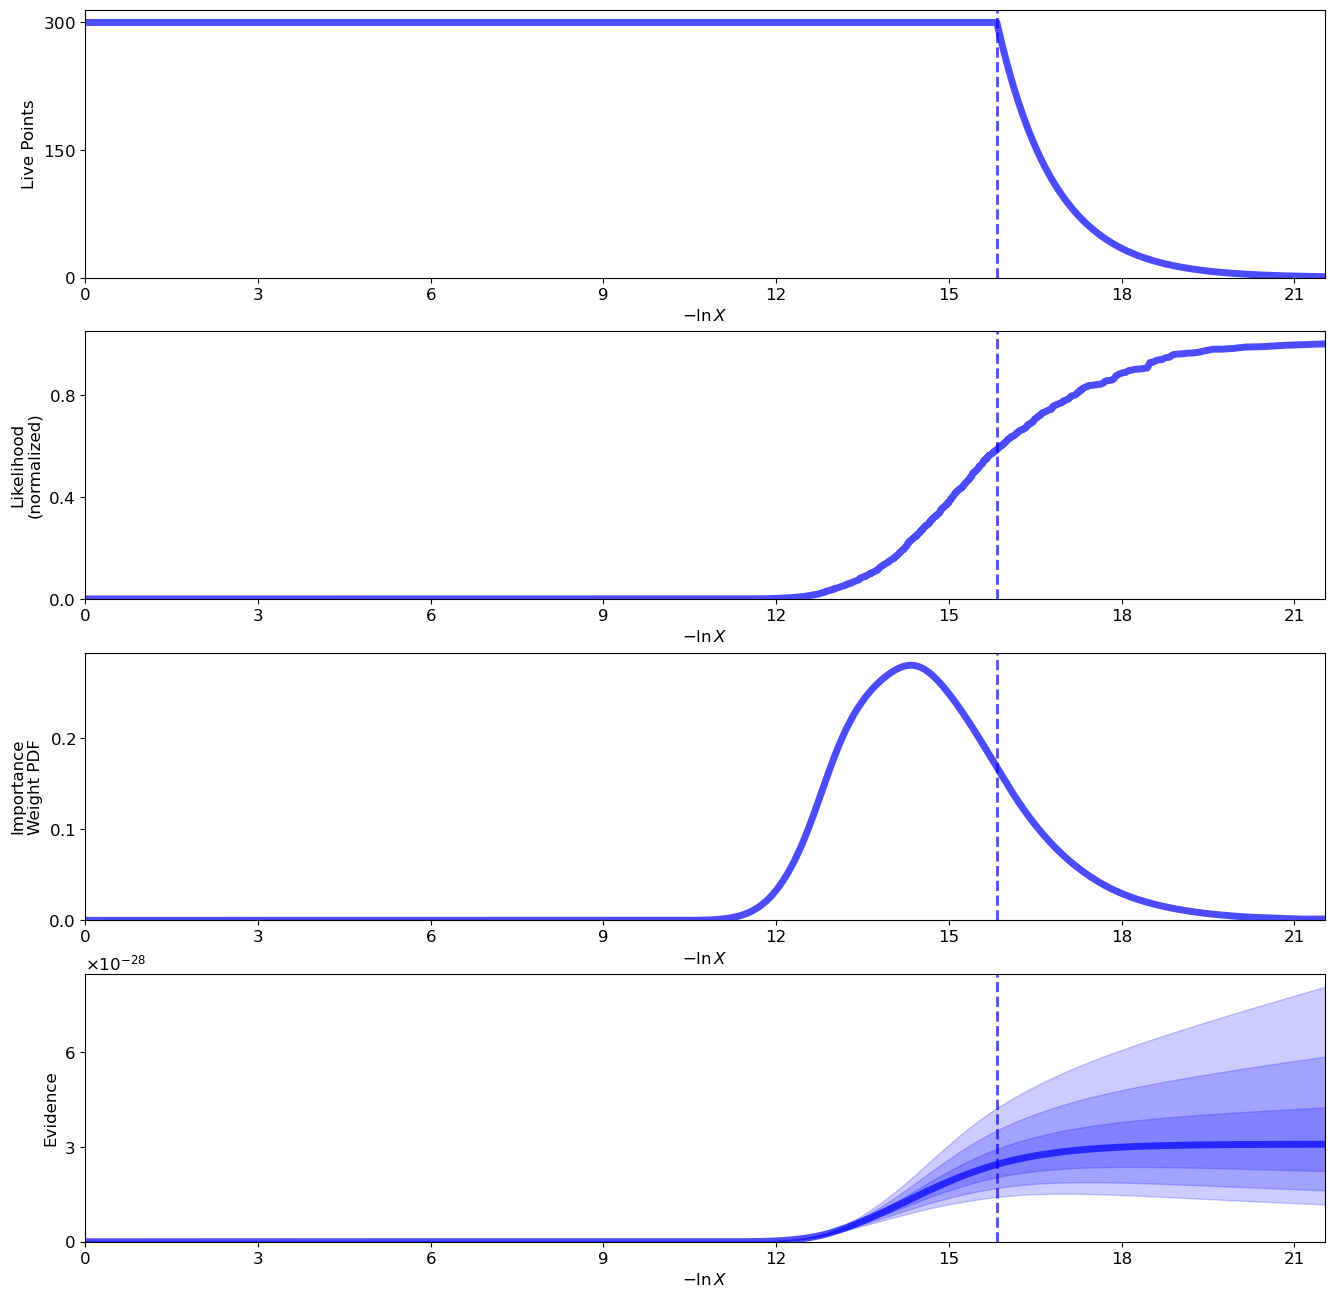

In [11]:
from dynesty import plotting as dyplot

#Plot a summary of the run
rfig, raxes=dyplot.runplot(sresults_b)

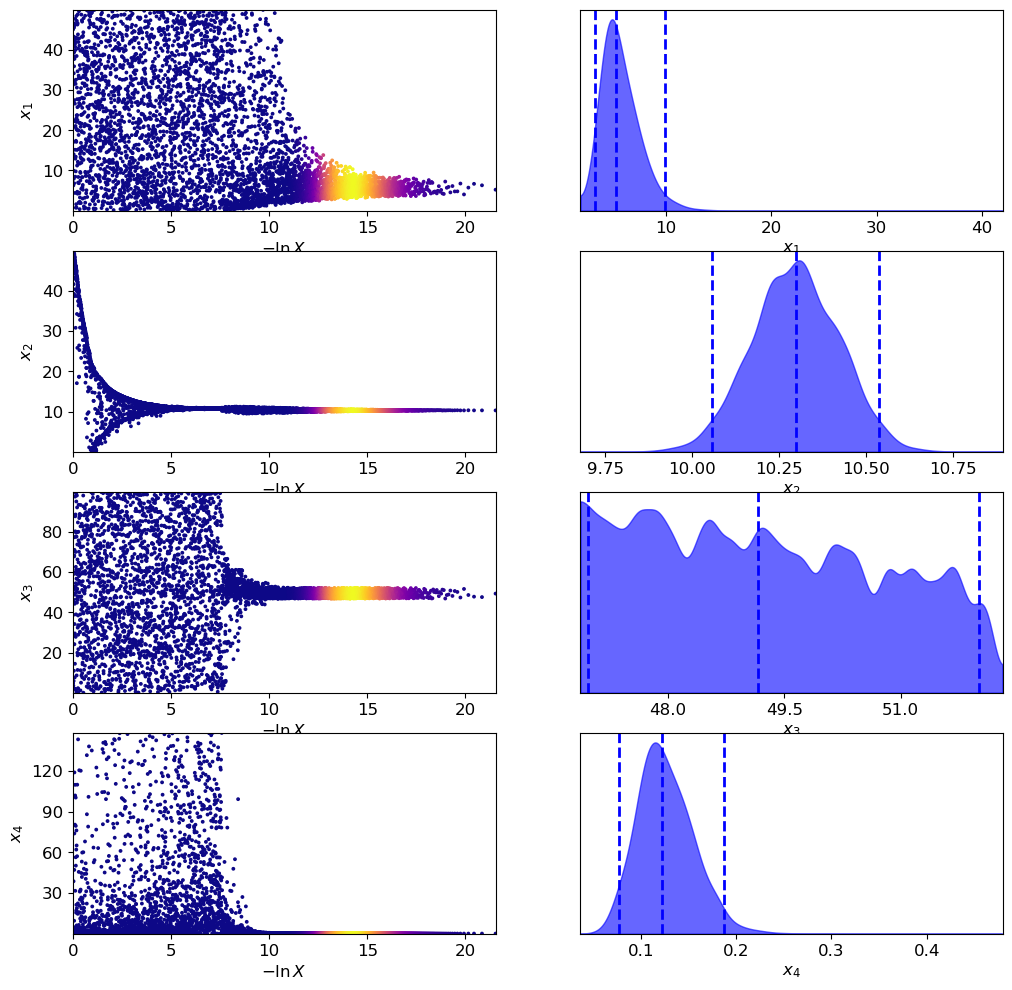

In [12]:
tfig, taxes = dyplot.traceplot(sresults_b)

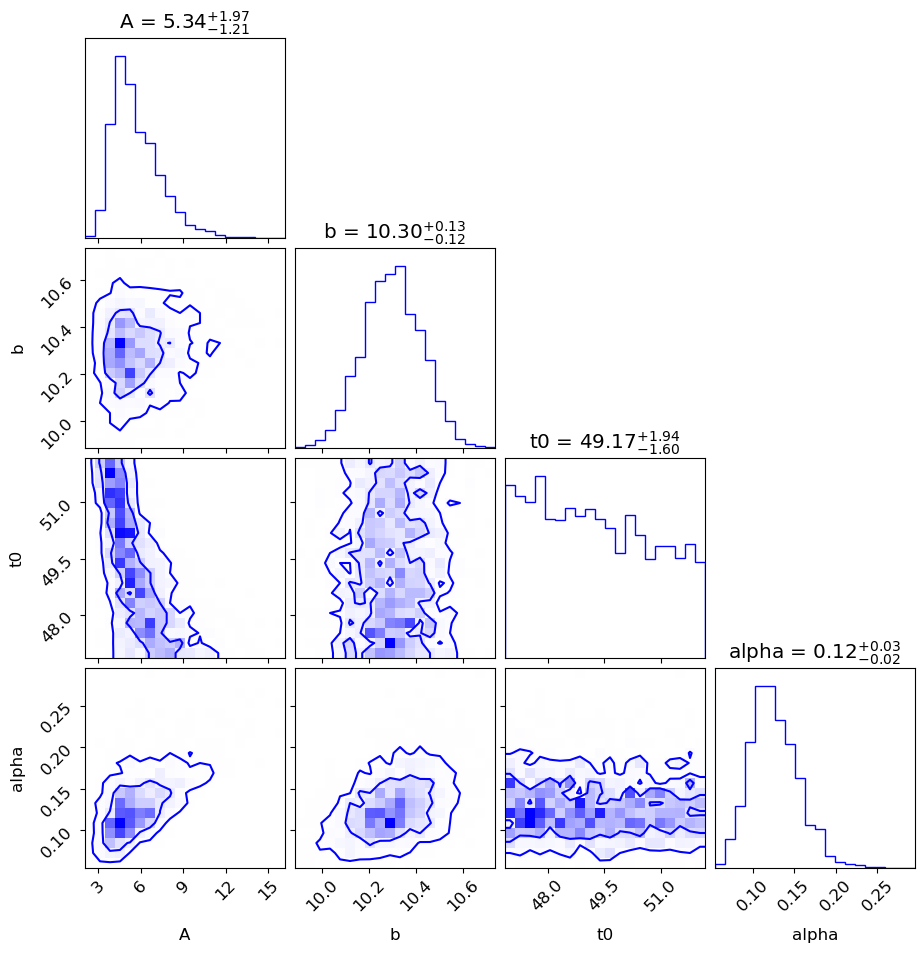

In [13]:
from dynesty import utils as dyfunc
import corner
samples = sresults_b.samples
weights = np.exp(sresults_b.logwt - sresults_b.logz[-1])#normalized weights


samples_equal = dyfunc.resample_equal(samples,weights)

labels=["A","b","t0","alpha"]
corner.corner(samples_equal,labels=labels,divergences=True,levels=[0.68,0.95],color='blue',plot_datapoints=False,show_titles=True);

In [14]:
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights) for samps in samples.T]
print("80% parameter credibl region are:"+str(quantiles))

mean, cov=dyfunc.mean_and_cov(samples,weights)
print("The mean and covariance of arameters are"+str(mean) +str(cov))

80% parameter credibl region are:[[3.859709269282115, 8.018629815292671], [10.136788403581969, 10.458110102431496], [47.27957033571394, 51.48117883351301], [0.09188373939818026, 0.16331452518450873]]
The mean and covariance of arameters are[ 5.70711748 10.2970464  49.27114687  0.12606027][[ 2.96098109e+00  1.48948878e-02 -1.74588416e+00  3.04332134e-02]
 [ 1.48948878e-02  1.52967567e-02 -1.57548780e-04  1.41235464e-03]
 [-1.74588416e+00 -1.57548780e-04  2.29324936e+00 -2.99758738e-03]
 [ 3.04332134e-02  1.41235464e-03 -2.99758738e-03  8.43048785e-04]]


In [15]:
evidence_b = sresults_b.logz[-1] #evidence
print(np.exp(evidence_b))

3.088303331477072e-28


- Gaussian model

In [16]:
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data,'gaussian_model'],ptform_args=['gaussian_model'],nlive=300)
sampler.run_nested()
sresults_g = sampler.results

5017it [09:07,  9.17it/s, +300 | bound: 150 | nc: 1 | ncall: 77882 | eff(%):  6.853 | loglstar:   -inf < -52.460 <    inf | logz: -67.942 +/-  0.220 | dlogz:  0.001 >  0.309]


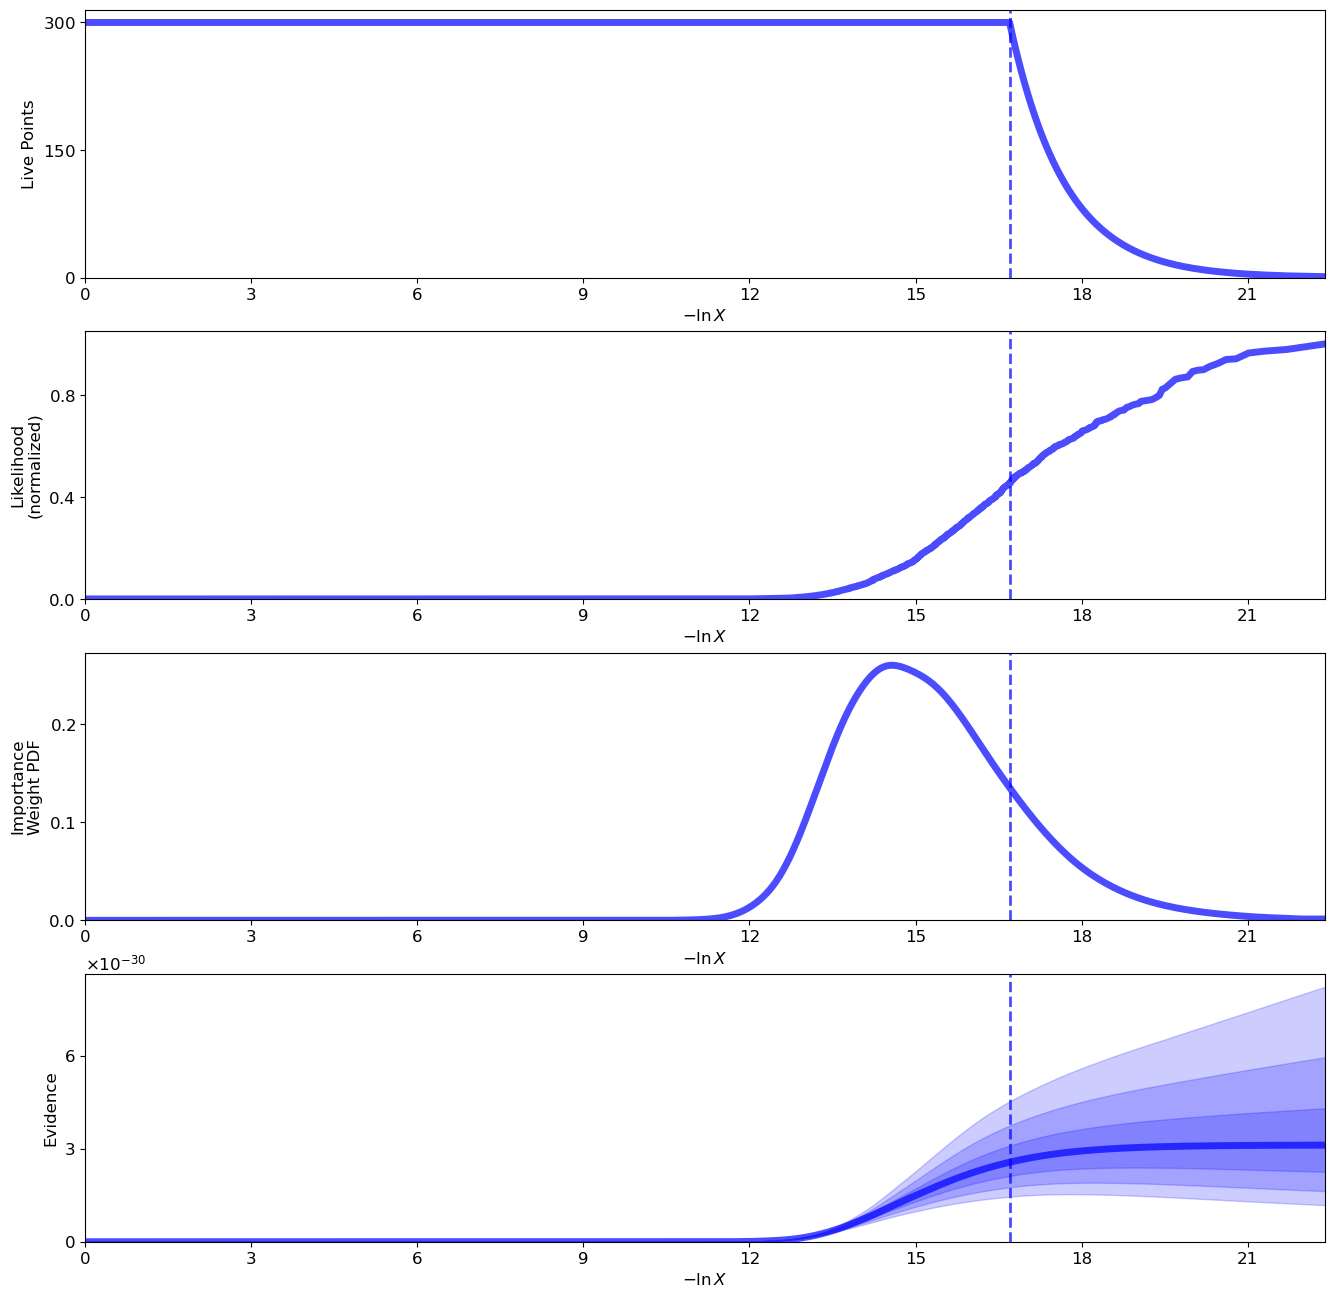

In [17]:
#Plot a summary of the run
rfig, raxes=dyplot.runplot(sresults_g)

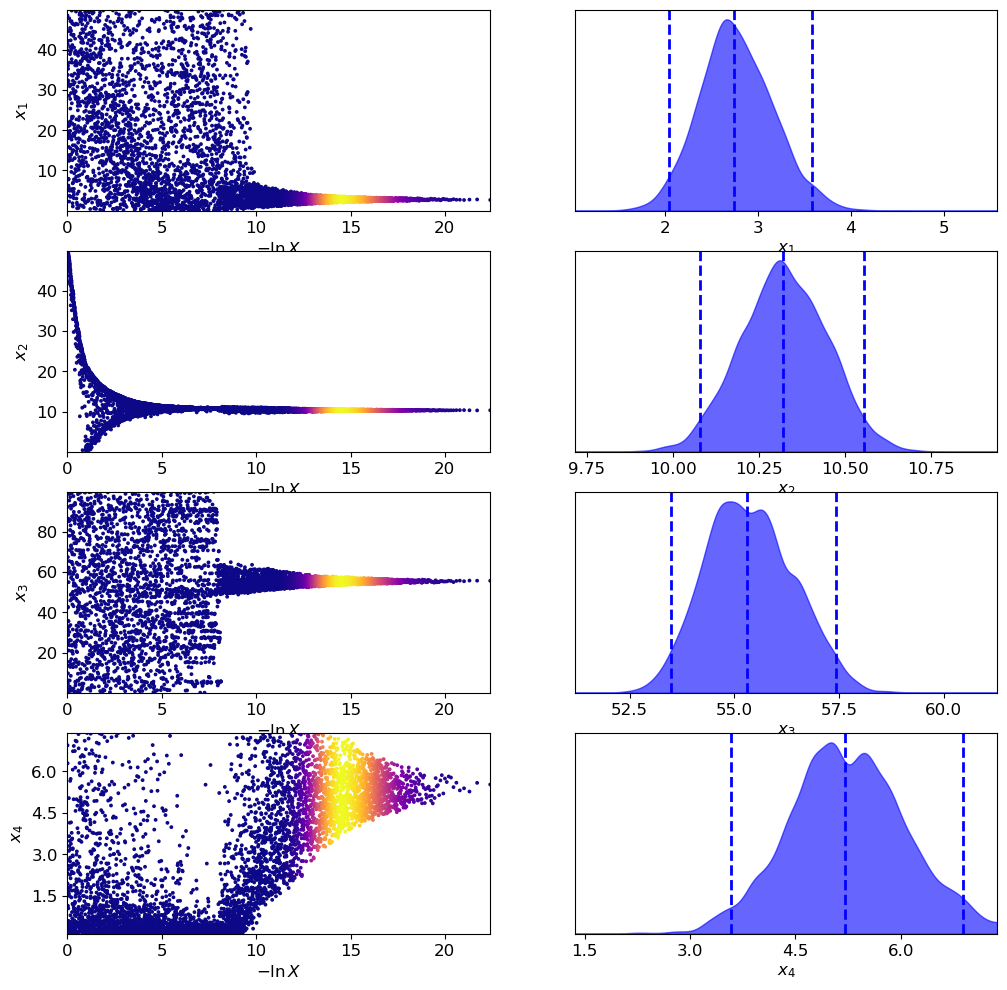

In [18]:
tfig, taxes = dyplot.traceplot(sresults_g)

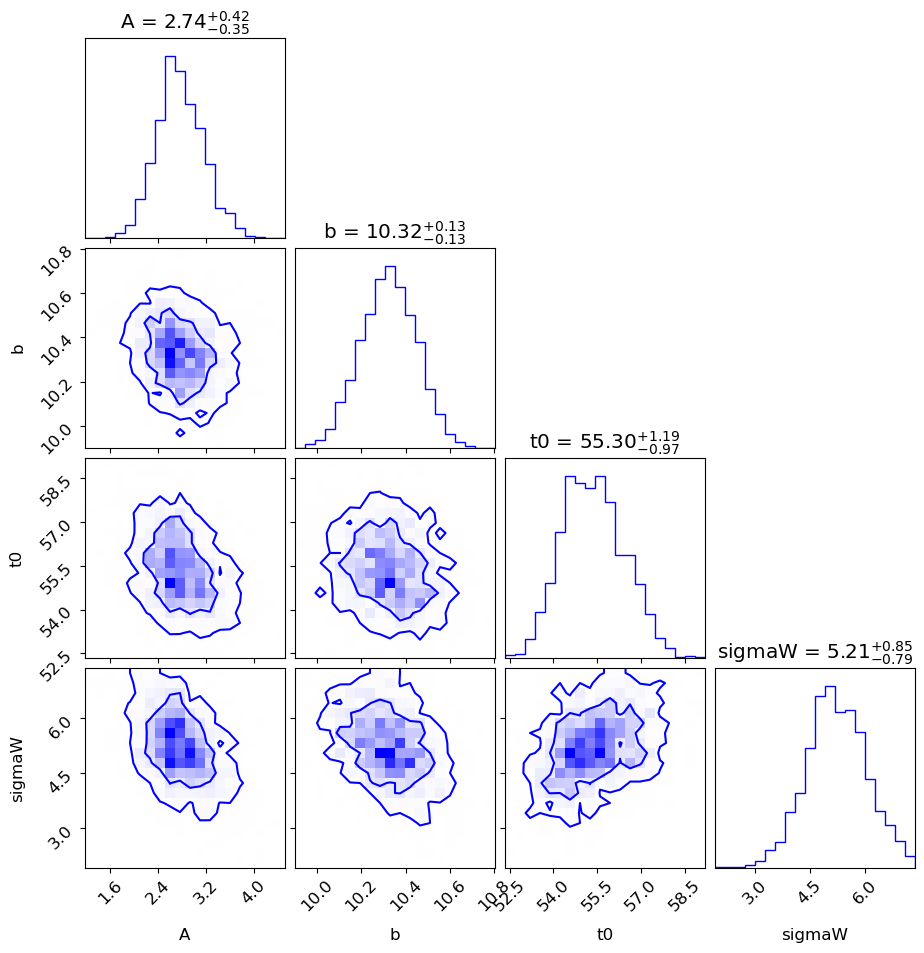

In [19]:
samples = sresults_g.samples
weights = np.exp(sresults_g.logwt - sresults_g.logz[-1])#normalized weights

samples_equal = dyfunc.resample_equal(samples,weights)

labels=["A","b","t0","sigmaW"]
corner.corner(samples_equal,labels=labels,divergences=True,levels=[0.68,0.95],color='blue',plot_datapoints=False,show_titles=True);

In [20]:
evidence_g = sresults_g.logz[-1] #evidence
print(np.exp(evidence_g))

3.112235668307533e-30


In [21]:
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights) for samps in samples.T]
print("80% parameter credibl region are:" +str(quantiles))

mean, cov=dyfunc.mean_and_cov(samples,weights)
print("The mean and covariance of parameters are"+str(mean) +str(cov))

80% parameter credibl region are:[[2.2884497424512134, 3.2835630789844603], [10.162925093401334, 10.482486210094804], [54.064953312678085, 56.775518857623965], [4.182403177257932, 6.297053902270606]]
The mean and covariance of arameters are[ 2.76922184 10.32251959 55.36339234  5.23278184][[ 0.15335142 -0.01104513 -0.13542496 -0.12950256]
 [-0.01104513  0.01559118 -0.0243886  -0.03818657]
 [-0.13542496 -0.0243886   1.07800951  0.31950819]
 [-0.12950256 -0.03818657  0.31950819  0.67722071]]


### 9) 
Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [22]:
# Let's compute the Bayes factor

log_bayes_factor = evidence_b / evidence_g
bayes_factor = np.exp(evidence_b)/ np.exp(evidence_g)
print("Log. Bayes factor=",log_bayes_factor)
print("Bayes factor=",bayes_factor)

Log. Bayes factor= 0.9323329251216771
Bayes factor= 99.23102427383093
